In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

/content/drive/My Drive/ml-project-2-marmlla_2


In [30]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF,BondCH,BondUS
0,2003-09-17,5398.899902,1025.97,1.3807,3.700,5.71
1,2003-09-18,5422.600098,1039.58,1.3858,3.716,5.69


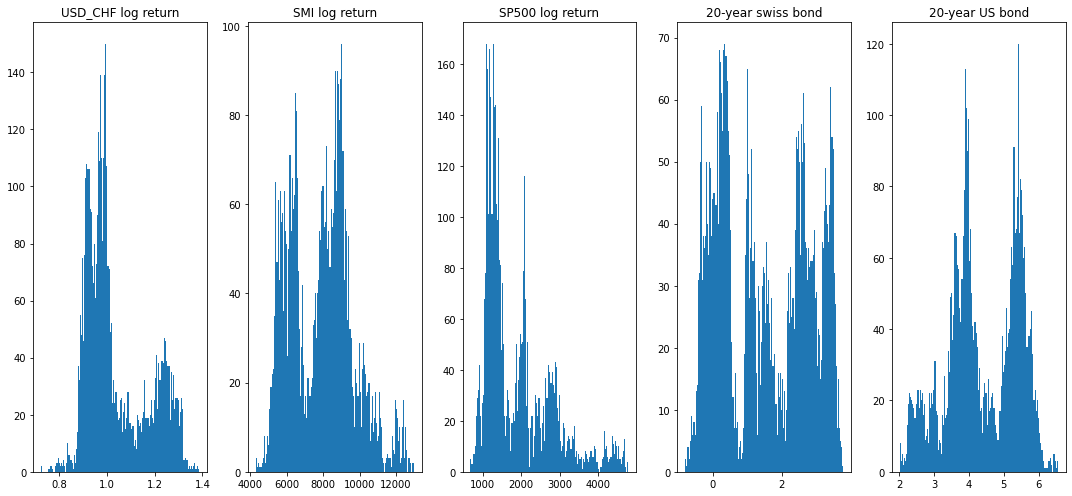

In [31]:
data = [df.USD_CHF, df.SMI, df.SP500, df.BondCH, df.BondUS]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF log return','SMI log return', 'SP500 log return', '20-year swiss bond', '20-year US bond']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

In [131]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=5, norm_=False, fraction_val_=0.1, fraction_test_=0.15)

Shape:             
X train     (3447, 5, 5), y train     (3447, 5)            
X train val (383, 5, 5) , y train val (383, 5)             
X test      (676, 5, 5) , y test      (676, 5)


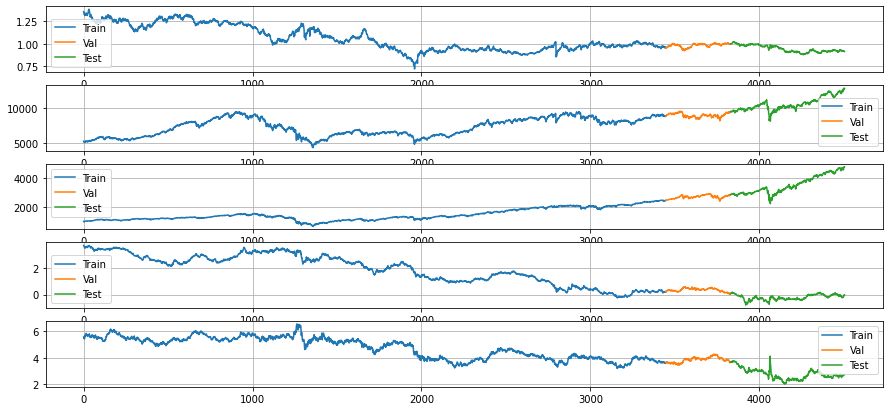

In [132]:
l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(15, 7))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.plot(np.arange(l1), train_y[:,i], label='Train')
  plt.plot(np.arange(l1, l2), val_y[:,i], label='Val')
  plt.plot(np.arange(l2,l3), test_y[:,i], label='Test')
  plt.grid()
  plt.legend()

plt.show()

# Price prediction 

### GRU (ONLY USD_CHF)

In [133]:
model_gru = ml.GRU_base(
        hidden_size=32,
        num_layers=1,
        input_size=1,
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05)
model_gru.to('cuda')
model_gru

GRU_base(
  (gru): GRU(1, 32, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [136]:
train_loss, val_loss = pl.train(model_gru, train_x[:,:,0].reshape(-1, 5,1), train_y, val_x[:,:,0].reshape(-1, 5,1), val_y, batch_size_= 512, num_epochs_=400, lr_=0.0001, device_='cuda')



 20%|██        | 82/400 [00:04<00:17, 17.72it/s]

Epoch: 80/400
MSE = [train loss mean :  0.53340774] , [val loss mean:  0.64632603, MSE (last) 9.39445%]


 41%|████▏     | 165/400 [00:07<00:08, 27.55it/s]

Epoch: 160/400
MSE = [train loss mean :  0.04458453] , [val loss mean:  0.03650266, MSE (last) 1.49410%]


 61%|██████    | 243/400 [00:10<00:05, 28.63it/s]

Epoch: 240/400
MSE = [train loss mean :  0.00235862] , [val loss mean:  0.01282426, MSE (last) 0.08633%]


 82%|████████▏ | 326/400 [00:13<00:02, 27.34it/s]

Epoch: 320/400
MSE = [train loss mean :  0.00075802] , [val loss mean:  0.00318583, MSE (last) 0.03957%]


100%|██████████| 400/400 [00:16<00:00, 24.17it/s]

Epoch: 400/400
MSE = [train loss mean :  0.00063682] , [val loss mean:  0.00113547, MSE (last) 0.06740%]


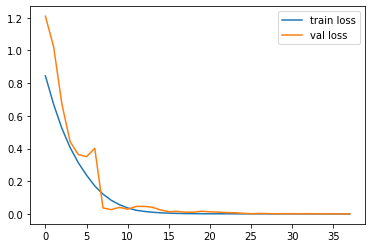

MSE: 0.13985786088130125%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2384.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          1.57e-223
Time:                        17:16:54   Log-Likelihood:                 1774.6
No. Observations:                 676   AIC:                            -3545.
Df Residuals:                     674   BIC:                            -3536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4434     

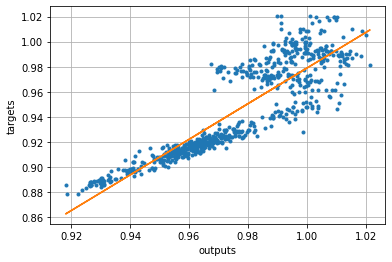

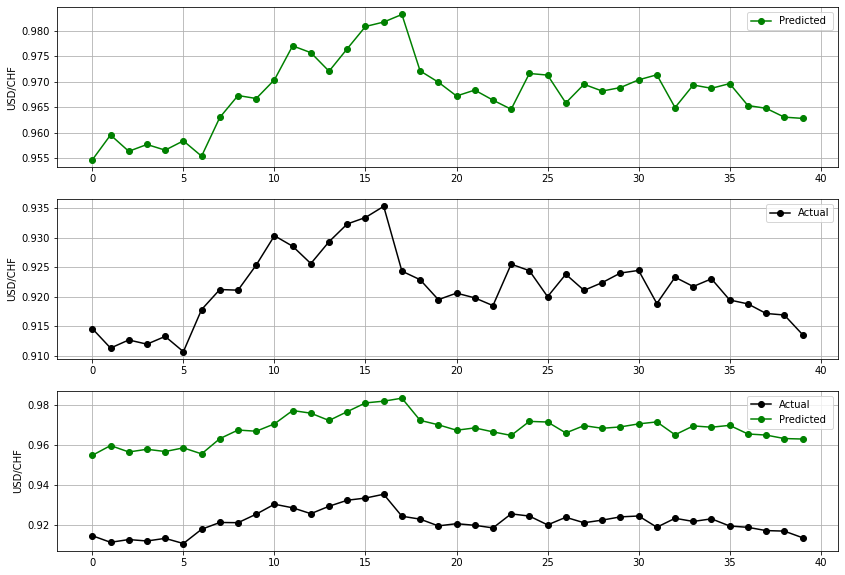

In [137]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()


outputs_simple, targets, MSE = pl.evaluate(model_gru, test_x[:,:,0].reshape(-1, 5,1), test_y, device='cuda') 
pl.regression_result(targets,outputs_simple)
ds.plot_result_price(outputs_simple, targets, nb=40)

### GRU (ALL features)

In [139]:

def min_max_norm(x_, y_): 
  y_ = y_.copy()
  min = x_.min(axis=1)
  max = x_.max(axis=1)
  d = []
 
  for i in range(x_.shape[2]):
    res = (x_[:,:,i] - min[:,i].reshape(-1,1)) / (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))
    d.append(res.reshape(-1,5, 1))
    y_[:,i] = ((y_[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))/ (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))).reshape(-1,)
  return np.concatenate(d, axis=2), y_

train_x_norm, train_y_norm = min_max_norm(train_x, train_y)
val_x_norm, val_y_norm  = min_max_norm(val_x, val_y)
test_x_norm, test_y_norm = min_max_norm(test_x, test_y)



In [140]:
model_gru_all = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size=5,
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05)
model_gru_all.to('cuda')
model_gru_all

GRU_base(
  (gru): GRU(5, 32, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [141]:
train_loss, val_loss = pl.train(model_gru_all, train_x_norm, train_y_norm, val_x_norm, val_y_norm, batch_size_=512, num_epochs_=200, lr_=0.0001, device_='cuda')
# 0.005% score in validation 


 22%|██▎       | 45/200 [00:01<00:06, 25.35it/s]

Epoch: 40/200
MSE = [train loss mean :  1.07702783] , [val loss mean:  0.89404685, MSE (last) 71.39663%]


 42%|████▏     | 84/200 [00:03<00:04, 24.80it/s]

Epoch: 80/200
MSE = [train loss mean :  0.80485191] , [val loss mean:  0.63247535, MSE (last) 58.26374%]


 62%|██████▏   | 123/200 [00:04<00:02, 25.69it/s]

Epoch: 120/200
MSE = [train loss mean :  0.73858169] , [val loss mean:  0.55625291, MSE (last) 54.27577%]


 82%|████████▎ | 165/200 [00:06<00:01, 25.54it/s]

Epoch: 160/200
MSE = [train loss mean :  0.71675868] , [val loss mean:  0.53516469, MSE (last) 52.84413%]


100%|██████████| 200/200 [00:07<00:00, 25.01it/s]

Epoch: 200/200
MSE = [train loss mean :  0.70597416] , [val loss mean:  0.52792994, MSE (last) 52.63186%]


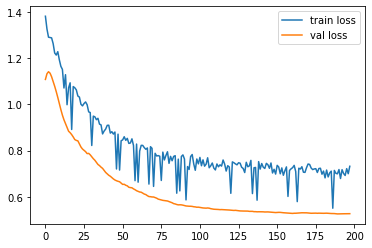

MSE: 56.13737341091031%
REAL MSE: 0.0018054542348305432
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 5.152e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:17:22   Log-Likelihood:                 2733.5
No. Observations:                 676   AIC:                            -5463.
Df Residuals:                     674   BIC:                            -5454.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

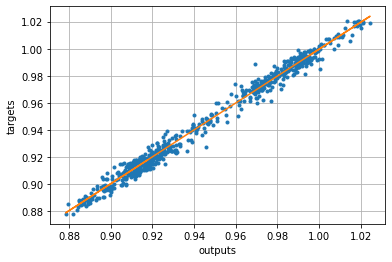

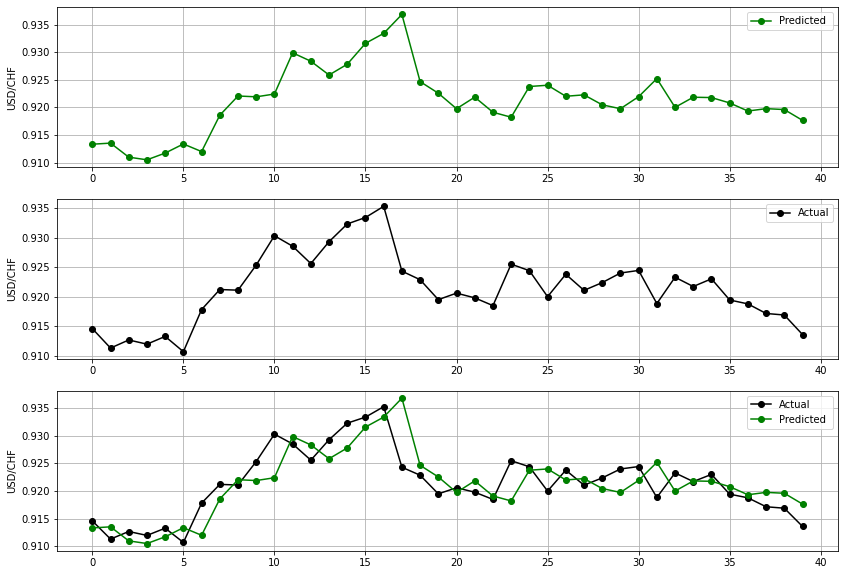

In [142]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 1)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 1)[1:] , label="val loss")
plt.legend()
plt.show()


outputs, targets, MSE = pl.evaluate(model_gru_all, test_x_norm, test_y_norm, device='cuda') 

min = test_x.min(axis=1)
max = test_x.max(axis=1)
o = outputs.reshape(-1,)* (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((o-t)**2)*100)

pl.regression_result(t,o)

ds.plot_result_price(o, t, nb=40)

### GRU (AUX block)

In [150]:
gru_model_aux = ml.ExchangeRateNet(num_layers=2)
gru_model_aux.to('cuda')
gru_model_aux

ExchangeRateNet(
  (gru_general): GRU_base(
    (gru): GRU(5, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_ex_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_0): Linear(in_features=32, out_features=32, bias=True)
    (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_1): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
  )
  (gru_SPI_reg): GRU_base(
    (gru): GRU(1, 32, batch_first=True, dropout=0.05)
    (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, t

In [151]:
train_loss, val_loss, aux_loss, aux_loss_val = pl.train_aux(gru_model_aux, train_x_norm, train_y_norm, val_x_norm, val_y_norm, batch_size_=512, num_epochs_=300, lr_=0.0001, device_='cuda')


 20%|██        | 60/300 [00:12<01:09,  3.45it/s]

Epoch: 60/300
MSE = [train loss mean :  1.09071247] , [val loss mean:  0.88043380, MSE (last) 80.89692%]
Aux loss train: [close:  0.87124 ], [SMI:  0.51552 ], [SP500:  0.60961 ], [bondCH:  1.71255 ] [bondUS:  0.55958 ] [Gru base:  1.23278]
Aux loss val:   [close:  0.60145 ], [SMI:  0.47238 ], [SP500:  0.50820 ], [bondCH:  1.37632 ] [bondUS:  0.58917 ] [Gru base:  0.98881]


 40%|████      | 121/300 [00:23<00:27,  6.61it/s]

Epoch: 120/300
MSE = [train loss mean :  0.96322591] , [val loss mean:  0.74294006, MSE (last) 68.49026%]
Aux loss train: [close:  0.72973 ], [SMI:  0.48102 ], [SP500:  0.51515 ], [bondCH:  0.80271 ] [bondUS:  0.47016 ] [Gru base:  0.78842]
Aux loss val:   [close:  0.52613 ], [SMI:  0.42970 ], [SP500:  0.38190 ], [bondCH:  0.71793 ] [bondUS:  0.45144 ] [Gru base:  0.60230]


 60%|██████    | 181/300 [00:33<00:18,  6.38it/s]

Epoch: 180/300
MSE = [train loss mean :  0.84823694] , [val loss mean:  0.62038877, MSE (last) 56.55461%]
Aux loss train: [close:  0.72774 ], [SMI:  0.48151 ], [SP500:  0.51386 ], [bondCH:  0.61696 ] [bondUS:  0.46271 ] [Gru base:  0.70226]
Aux loss val:   [close:  0.52272 ], [SMI:  0.43048 ], [SP500:  0.37792 ], [bondCH:  0.54410 ] [bondUS:  0.44456 ] [Gru base:  0.51780]


 80%|████████  | 241/300 [00:42<00:09,  6.52it/s]

Epoch: 240/300
MSE = [train loss mean :  0.75823382] , [val loss mean:  0.53470854, MSE (last) 51.67862%]
Aux loss train: [close:  0.73534 ], [SMI:  0.47997 ], [SP500:  0.50869 ], [bondCH:  0.58885 ] [bondUS:  0.45790 ] [Gru base:  0.69332]
Aux loss val:   [close:  0.52057 ], [SMI:  0.43176 ], [SP500:  0.37802 ], [bondCH:  0.51253 ] [bondUS:  0.44305 ] [Gru base:  0.51086]


100%|██████████| 300/300 [00:51<00:00,  5.81it/s]

Epoch: 300/300
MSE = [train loss mean :  0.70408128] , [val loss mean:  0.51219988, MSE (last) 51.01189%]
Aux loss train: [close:  0.72119 ], [SMI:  0.48061 ], [SP500:  0.50668 ], [bondCH:  0.57678 ] [bondUS:  0.45625 ] [Gru base:  0.66863]
Aux loss val:   [close:  0.52073 ], [SMI:  0.43227 ], [SP500:  0.37761 ], [bondCH:  0.51240 ] [bondUS:  0.44405 ] [Gru base:  0.51342]


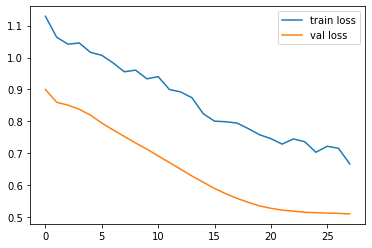

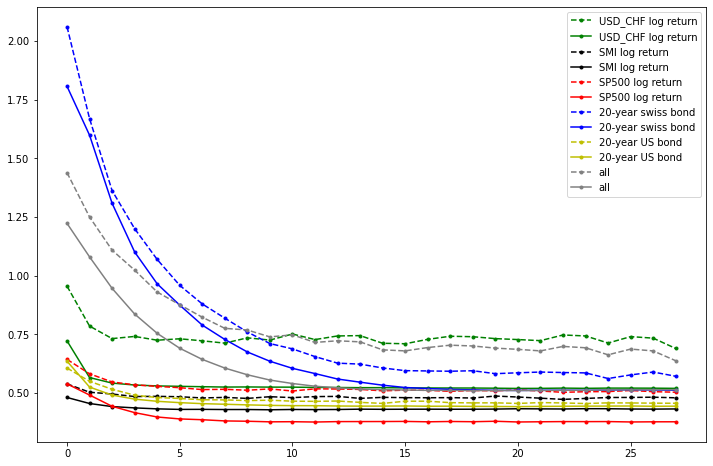

MSE: 56.435073545595834%
REAL MSE: 0.0017016591283277142
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.476e+04
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:27:47   Log-Likelihood:                 2753.9
No. Observations:                 676   AIC:                            -5504.
Df Residuals:                     674   BIC:                            -5495.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

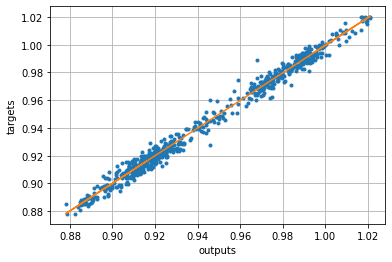

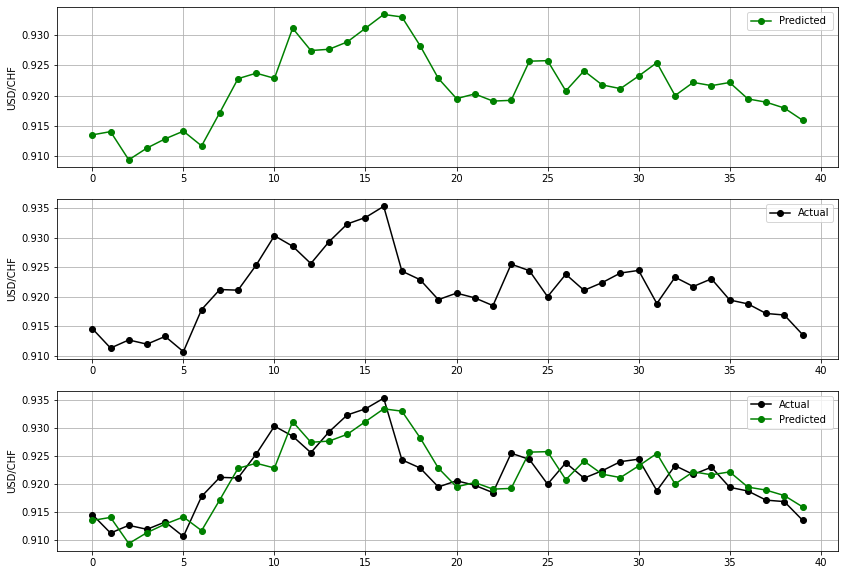

In [152]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
name  = ['USD_CHF log return','SMI log return', 'SP500 log return', '20-year swiss bond', '20-year US bond', 'all']
color= ['g', 'k', 'r', 'b', 'y', 'grey']
for i in range(len(aux_loss)): 
  plt.plot(pl.smooth_loss(aux_loss[i], chunksize = 10)[1:],'.--', label=name[i], c=color[i])
  plt.plot(pl.smooth_loss(aux_loss_val[i], chunksize = 10)[1:],'.-' ,label=name[i], c=color[i])
plt.legend()
plt.show()

outputs, targets, MSE = pl.evaluate_aux(gru_model_aux, test_x_norm, test_y_norm, device='cuda') 

min = test_x.min(axis=1)
max = test_x.max(axis=1)
o_aux = outputs.reshape(-1,)* (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((o_aux-t)**2)*100)

pl.regression_result(t,o_aux)

ds.plot_result_price(o_aux, t, nb=40)


# Result 

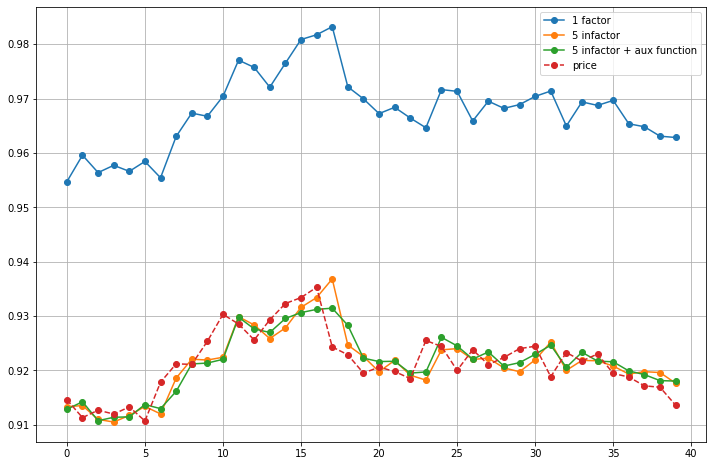

In [146]:
nb = 40
plt.figure(figsize=(12,8))
plt.plot(outputs_simple[-nb:],'o-', label="1 factor")
plt.plot(o[-nb:],'o-' , label="5 infactor")
plt.plot(o_aux[-nb:],'o-' , label="5 infactor + aux function")
plt.plot(t[-nb:],'o--', label="price")
plt.grid()
plt.legend()
plt.show()

#### Test for check normalisation...

In [ ]:
plt.plot(test_y[-40:,0])
plt.show()
min = test_x.min(axis=1)
max = test_x.max(axis=1)
plt.plot(test_y_norm[-40:,0] * (max[-40:,0] - min[-40:,0]) + min[-40:,0])
plt.show()
plt.plot(test_y_norm[-40:,0])